In [117]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast
from tqdm import tqdm

warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [118]:
# Use this chunk to generate the dataset if not already created
# df = pd.DataFrame()
# files = os.listdir("./data/patients_new")
# for file in files:
    # patient = pd.read_json(os.path.join("./data/patients_new/", file))
    # df = pd.concat([df, patient], ignore_index=True)
# df.reset_index(drop=True)
# df.to_csv("./collated_dataset.csv", index=False)

df = pd.read_csv("./collated_dataset.csv")

In [119]:
# Take the sub-datasets (patients, hosp, poe, etc.), flatten them and append them to the main dataframe
def normalize_jsons(column, dropper, sorter):
    data = []
    # for each row's json
    for datum in column:
        json_df = pd.json_normalize(ast.literal_eval(datum)[0]) if pd.json_normalize(ast.literal_eval(datum)[0]).iloc[0, 0] else None
        data.append(json_df)
    column_df = pd.concat(data, ignore_index=True).drop_duplicates(subset=dropper).sort_values(by=sorter).reset_index(drop=True)
    return column_df

In [120]:
df = pd.merge(df, normalize_jsons(df["patients"], ["subject_id"], ["anchor_year", "subject_id"]), how='left', on="subject_id", suffixes=("", ""))
df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,prescriptions,procedures_icd,services,transfers,icustays,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,"[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853....",[],F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357....",[],F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920....",[],F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 29079034,...",[],"[{'subject_id': 10000032, 'hadm_id': 29079034,...","[{'subject_id': 10000032, 'hadm_id': 29079034....","[{'subject_id': 10000032, 'hadm_id': 29079034,...",F,52,2180,2014 - 2016,2180-09-09
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,EW EMER.,P4645A,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,"[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018....","[{'subject_id': 10001217, 'hadm_id': 24597018,...",F,55,2157,2011 - 2013,


In [121]:
# Normalize admit and discharge times, and calculate length of stay
df = df.sort_values(by=["admittime"]).reset_index(drop=True)
df['admittime_wy'] = df['admittime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df['dischtime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df.apply(lambda row: pd.to_datetime(row['dischtime_wy']).replace(year=2025) if row['dischtime_wy'].month < row['admittime_wy'].month else row['dischtime_wy'], axis=1)
df["length_of_stay"] = pd.to_datetime(df["dischtime_wy"]) - pd.to_datetime(df["admittime_wy"])

In [122]:
# Take the sub-datasets (patients, hosp, poe, etc.), flatten them and append them to the main dataframe
def normalize_json_list(column, dropper, sorter):
    data = []
    # for each row's json
    for datum in tqdm(column):
        # convert all the jsons in the list to a set of df columns
        json_df = pd.json_normalize(ast.literal_eval(datum))
        data.append(json_df)
    # compile to a df, drop duplicates and reset index
    column_df = pd.concat(data, ignore_index=True).drop_duplicates(subset=dropper).sort_values(by=sorter).reset_index(drop=True)
    return column_df

In [123]:
df = pd.merge(df, normalize_json_list(df["emar"], ["subject_id", "hadm_id", "emar_id"], ["subject_id", "charttime"]), how='left', on=["subject_id", "hadm_id"], suffixes=("", "")).drop(["0"], axis=1)
df["hadm_emar_id"] = df["hadm_id"].apply(lambda x: str(x)) + df["emar_id"].apply(lambda x: str(x))
df.head()

100%|██████████| 275/275 [00:18<00:00, 14.84it/s]


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime,medication,event_txt,scheduletime,storetime,hadm_emar_id
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25563031nan
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20291550nan
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21255400nan
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22942076nan
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29462354nan


In [124]:
def plot_histogram(x1, bins, title, x_label, y_label, color1, lcolor1, x2=None, color2=None, lcolor2=None):
    ax = x1.hist(bins=bins, xlabelsize=10, ylabelsize=6, color=color1)
    plt.axvline(x1.median(), color=lcolor1, linestyle='dashed', linewidth=2)

    if x2 is not None:
        ax2 = x2.hist(bins=bins, xlabelsize=10, ylabelsize=6, color=color2)
        plt.axvline(x2.median(), color=lcolor2, linestyle='dashed', linewidth=2)

    ax.set_title(title, weight='bold')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(False)
    plt.show()

In [125]:
meds = df[(df["medication"] != "") & (df["medication"] != "Sodium Chloride 0.9%  Flush") & (df["event_txt"] == "Administered")]
meds["medication"].value_counts()

Insulin                1519
Heparin                1177
Metoprolol Tartrate     800
Acetaminophen           683
Docusate Sodium         565
                       ... 
Naloxone                  1
Neostigmine               1
AcetaZOLamide             1
Etomidate                 1
Lidocaine 2%              1
Name: medication, Length: 425, dtype: int64

In [ ]:
# Let's look at the number of medications received by each patient depending on their attributes

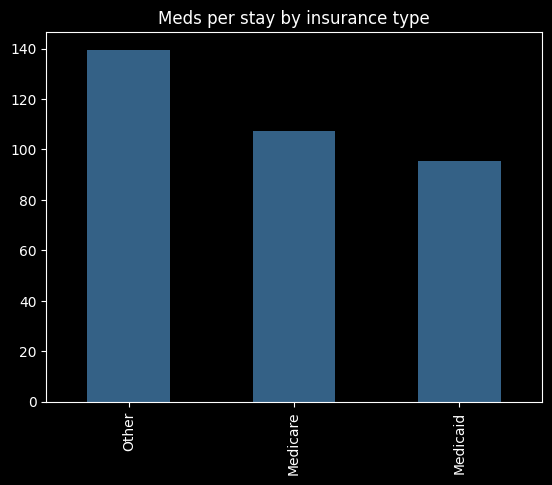

In [126]:
# Medicaid patients receive significantly fewer medications over the course of their stay
admits = meds.drop_duplicates(subset=["hadm_id"])
ax = (meds["insurance"].value_counts() / admits["insurance"].value_counts()).plot.bar(color="steelblue", alpha=0.75, title="Meds per stay by insurance type")
plt.show()

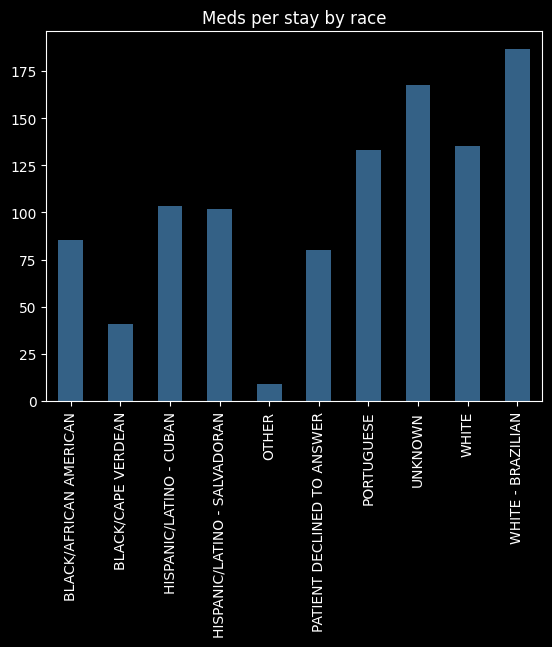

In [127]:
ax = (meds["race"].value_counts() / admits["race"].value_counts()).plot.bar(color="steelblue", alpha=0.75, title="Meds per stay by race")
plt.show()

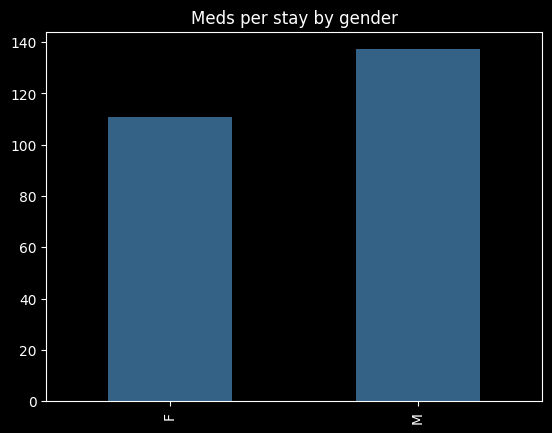

In [132]:
ax = (meds["gender"].value_counts() / admits["gender"].value_counts()).plot.bar(color="steelblue", alpha=0.75, title="Meds per stay by gender")
plt.show()

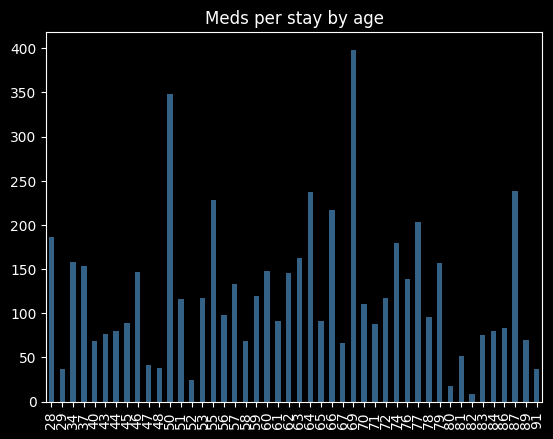

In [134]:
ax = (meds["anchor_age"].value_counts() / admits["anchor_age"].value_counts()).plot.bar(color="steelblue", alpha=0.75, title="Meds per stay by age")
plt.show()

In [ ]:
# Let's also look at the duration of the interaction in each medicine's administration, by their attributes

In [128]:
# Calculate the time between schedule and chart
meds['charttime_wy'] = meds['charttime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
meds['scheduletime_wy'] = meds['scheduletime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
meds["admin_delay"] = meds.apply(lambda x: (pd.to_datetime(x["charttime_wy"]) - pd.to_datetime(x["scheduletime_wy"])) if (pd.to_datetime(x["charttime_wy"]) >= pd.to_datetime(x["scheduletime_wy"])) else (pd.to_datetime(x["scheduletime_wy"]) - pd.to_datetime(x["charttime_wy"])), axis=1)
meds = meds[meds["admin_delay"] <= '12 hours']
meds["admin_delay"].mean()

Timedelta('0 days 00:32:53.573362208')

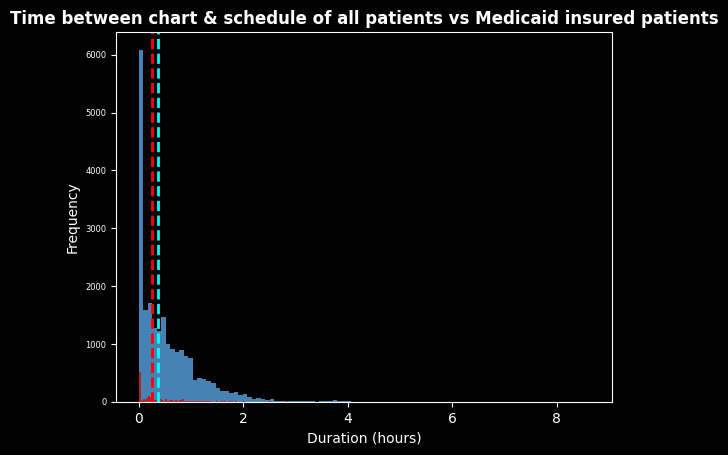

Non-Medicaid-insured patients: 0 days 00:33:20.985394352
Medicaid-insured patients: 0 days 00:27:06.871921182


In [129]:
# Medicaid patients experience slightly fewer delays between schedule and chart
medicaid_df = meds[(meds["insurance"] == "Medicaid")]
main_df = meds[(~meds.index.isin(medicaid_df.index))]

plot_histogram((meds["admin_delay"].dt.total_seconds() / 3600), 100, "Time between chart & schedule of all patients vs Medicaid insured patients", "Duration (hours)", "Frequency", "steelblue", "aqua", (medicaid_df["admin_delay"].dt.total_seconds() / 3600), "firebrick", "red")

print(f"Non-Medicaid-insured patients: {main_df['admin_delay'].mean()}")
print(f"Medicaid-insured patients: {medicaid_df['admin_delay'].mean()}")

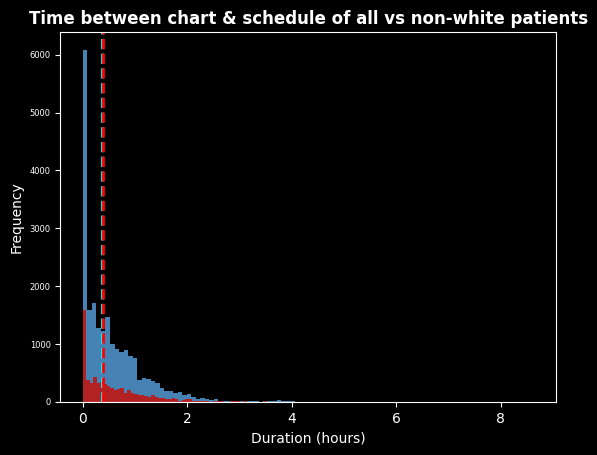

White patients: 0 days 00:32:16.190352697
Non-white patients: 0 days 00:34:19.121661721


In [130]:
# Medicaid patients experience slightly fewer delays between schedule and chart
non_white_df = meds[~meds["race"].str.contains("WHITE")]
main_df = meds[~meds.index.isin(non_white_df.index)]

plot_histogram((meds["admin_delay"].dt.total_seconds() / 3600), 100, "Time between chart & schedule of all vs non-white patients", "Duration (hours)", "Frequency", "steelblue", "aqua", (non_white_df["admin_delay"].dt.total_seconds() / 3600), "firebrick", "red")

print(f"White patients: {main_df['admin_delay'].mean()}")
print(f"Non-white patients: {non_white_df['admin_delay'].mean()}")

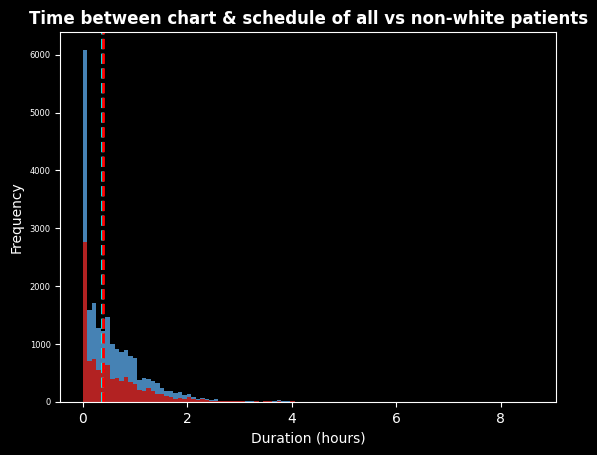

Male patients: 0 days 00:32:19.239904988
Female patients: 0 days 00:33:35.680562531


In [131]:
# Medicaid patients experience slightly fewer delays between schedule and chart
female_df = meds[meds["gender"] == "F"]
main_df = meds[~meds.index.isin(female_df.index)]

plot_histogram((meds["admin_delay"].dt.total_seconds() / 3600), 100, "Time between chart & schedule of all vs non-white patients", "Duration (hours)", "Frequency", "steelblue", "aqua", (female_df["admin_delay"].dt.total_seconds() / 3600), "firebrick", "red")

print(f"Male patients: {main_df['admin_delay'].mean()}")
print(f"Female patients: {female_df['admin_delay'].mean()}")